The use of this software is governed by the license file contained within its original repository, available here: [License file](https://github.com/fmglobal/1D-LIB-TR/blob/57549ec87f338b8554b3a5f84ef95029e994bce9/LICENSE)

# Introduction

This notebook solves the governing equations set out in the paper:

*"[Modeling initiation and propagation of thermal runaway in pouch Li-ion battery cells: effects of heating rate and state-of-charge](https://doi.org/10.1016/j.proci.2024.105316)"*,\
Dong Zeng, Danyal Mohaddes, Lauren Gagnon and Yi Wang,\
Proceedings of the Combustion Institute, 2024.


- Physical and numerical parameters, boundary conditions and initial conditions are set at the top under [Parameters](#Parameters)
- The physical model is defined under [Model](#Model)
- A simple first-order explicit solver with adaptive time stepping is defined under [Solver](#Solver)
- The problem is solved and post-processed under [Solve and post-process](#Solve-and-post-process)

Content in this repository developed by Danyal Mohaddes [danyal.mohaddes@fmglobal.com] and Dong Zeng [dong.zeng@fmglobal.com]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Parameters

## Physics

In [2]:
def copper_cp(T):
    """Compute the heat capacity of copper using the Shomate equation.
    Valid for 298K < T < 1358K.
    Reference: Chase, M.W., Jr., NIST-JANAF Themochemical Tables, Fourth Edition, J. Phys. Chem. Ref. Data, Monograph 9, 1998, 1-1951.
    [J/kg.K]"""

    M_Cu = 63.5/1000.0; # Molar mass of Cu [kg/mol]
    t = T / 1000
    A = 17.72891
    B = 28.09870
    C = -31.25289
    D = 13.97243
    E = 0.068611
    cp = A + B*t + C*t**2 + D*t**3 + E/t**2
    return cp/M_Cu

In [3]:
# -- Geometry --
# Length [m]
L = 0.0191
# Width [m]
W = 0.305
# Height [m]
H = 0.0856
# Volume [m3]
V = L * W * H
# Contact area [m2]
contact_area = W * H
# Ratio of plane perimiter to plane area [1/m]
gamma = 2.0 * (W + H) / (W * H)


# -- Thermophysics --
# Thermal conductivity [W/m/K]
k = 0.7
# Heat capacity [J/kg/K]
c = 880.0


# -- Model parameters --
# Gas venting time [s]
Deltat_v_g = 1.0
# Solid softening temperature [K]
T_v_s = 800.0
# Critical pressure for vent opening [PaG]
p_v = 879.9e3
# Maximum solid ejection fraction
f_s = 0.2

# -- Chemistry --
# Number of reactions (not counting sub-reactions for A_a^s decomposition)
N_r = 3
# Number of species (counting P^s + I^s as one species)
N_s = 5
# Rows: reactions 1, 2, 3
# Columns: species E^s, A_a^s, C_a^s, P^s+I^s, P^g
nup = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0]])
nupp = np.array([[0.0, 0.0, 0.0, 0.0, 1.0],
                [0.0, 0.0, 0.0, 0.75, 0.25],
                [0.0, 0.0, 0.0, 0.65, 0.35]])
assert nup.shape == (N_r, N_s)
assert nupp.shape == (N_r, N_s)
# Heats of reaction [J/kg]
Deltah = np.array([16.6, 1.5e6, 1.41e6]).reshape(-1, 1)
assert len(Deltah) == N_r
# Reaction order [-]
n = np.array([1.7, 1.48, 0.1, 2.0]).reshape(-1, 1)
assert len(n) == N_r + 1
# Arrhenius pre-exponential [1/s]
A = np.array([6.54e5, 3.14e6, 1.08e8, 53.7]).reshape(-1, 1)
assert len(A) == N_r + 1
# Arrhenius activation energy [J/mol]
E_a = np.array([6.59e4, 8.28e4, 1.1e5, 2.5e4]).reshape(-1, 1)
assert len(E_a) == N_r + 1


# -- Initial conditions --
# State of charge [-]
SOC = 1.0
# Density [kg/m3]
rho0 = 2366.0
# Temperature [K]
T0 = 298.0
# Species partial densities [kg_i/m3]
Y_E = 0.05
Y_A_a = SOC * 0.133 + 0.017
Y_C_a = SOC * 0.262 + 0.058
rhoY_0 = (rho0 * np.array([Y_E, Y_A_a, Y_C_a,
                           1.0 - (Y_E + Y_A_a + Y_C_a), 0.0])).reshape((-1, 1))
assert len(rhoY_0) == N_s


# -- Boundary conditions --
# left_boundary = {'type': 'adiabatic'}
# left_boundary = {'type': 'isothermal',
#                  'T': 1000.0}
# left_boundary = {'type': 'constant power',
#                  'power': 1040.0}
left_boundary = {'type': 'lumped',
                 'power': 1040.0,
                 'efficiency': 0.95,
                 'area': L * contact_area * gamma,
                 'R battery': 0.002,
                 'R insulation': np.inf,
                 'mass': 8941.0 * V,
                 'heat capacity': copper_cp
                 }
# Right boundary
# right_boundary = {'type': 'adiabatic'}
right_boundary = {'type': 'lumped',
                 'power': 0.0,
                 'efficiency': 0.95,
                 'area': L/3.0 * contact_area * gamma,
                 'R battery': 0.002,
                 'R insulation': np.inf,
                 'mass': 8941.0 * (contact_area * L/3.0),
                 'heat capacity': copper_cp
                 }


# -- Axial heat transfer --
# Heat transfer coefficient [W/m2/K]
h = 0.0
# Ambient temperature [K]
T_amb = T0


# -- Constants --
# Ideal gas constant [J/mol/K]
R = 8.314
# Molar mass of ethylene carbonate [kg/mol]
M_m = 25.818e-3
# Species index dictionary
species_idx = {
        'E^s': 0,
        'A_a^s': 1,
        'C_a^s': 2,
        'P^s+I^s': 3,
        'P^g': 4,
    }
assert len(species_idx) == N_s

## Numerics

In [4]:
# -- Spatial mesh --
# Number of gridpoints (including ghost cells) [-]
N = 190 + 2
assert N >= 3
# Grid spacing [m]
dx = L/(N-2)
# Cell volume [m3]
dV = dx * contact_area
# Construct the cell-centered LIB domain grid
x_grid = np.linspace(0.0-dx/2, L+dx/2, N)


# -- Temporal mesh --
# Maximum diffusive dt [s]
max_diff_dt = dx**2 * (rho0 * c / k)
t_max = 700.0


# -- Diffusion operator [1/m2] --
d2dx2 = np.zeros((N, N))
for i in range(1, N-1):
    d2dx2[i, i-1] = 1.0
    d2dx2[i, i] = -2.0
    d2dx2[i, i+1] = 1.0
d2dx2 *= 1.0/(dx**2)


# -- Constants --
# Division stabilizer [-]
SMALL = 1.0e-20
# Negative mass fraction limit [-]
MF_TOL = 1.0e-3
# Temperature change damping coefficient [-]
DAMP_T_v_s = 0.01
# Temperature rate-of-change indicative of TR [K/s]
dTdt_TR = 4.0


## Post-processing control

In [5]:
make_contour_plots = True
make_line_plots = True

if make_contour_plots or make_line_plots:
    os.makedirs("outputs", exist_ok=True)

# Model

## Precomputations

In [6]:
# Maximum mass of generated (and therefore ejected) gas [kg]
m_v_Pg_star = (nupp[:, species_idx['P^g']].reshape((1, N_r)).dot(
    rhoY_0[[species_idx['E^s'], species_idx['A_a^s'], species_idx['C_a^s']]]) * V).item()
assert m_v_Pg_star > 0.0

# Maximum mass of vented solids [kg]
m_v_Ps_plus_Is = f_s * rho0 * V
assert m_v_Ps_plus_Is > 0.0

# Lumped model constants
if left_boundary['type'] == 'lumped':
    alph_L = dx/k * 1.0/left_boundary['R battery']
    C1_L = (1.0-alph_L/2.0)/(1.0+alph_L/2.0)
    C2_L = alph_L/(1.0+alph_L/2.0)
    assert C1_L > 0.0
    assert C2_L > 0.0

if right_boundary['type'] == 'lumped':
    alph_R = dx/k * 1.0/right_boundary['R battery']
    C1_R = (1.0-alph_R/2.0)/(1.0+alph_R/2.0)
    C2_R = alph_R/(1.0+alph_R/2.0)
    assert C1_R > 0.0
    assert C2_R > 0.0

## Event tracking

In [7]:
class LIB:
    """Class to track events during TRP"""

    def __init__(self):
        # Vent state [-]
        self.vent_open = False
        # Time to vent opening [s]
        self.t_v_g = -1.0
        # rhoY_P^g at vent opening [kg/m3]
        self.rhoY_Pg_at_t_v_g = -1.0 * np.ones((N-2, 1))

    def reset(self):
        self.__init__()

## Source term components

In [8]:
def mean_pressure(rhoY_Pg, T):
    """Compute the mean pressure in the LIB cell based on the gaseous partial density.
    This is gauge pressure.
    [Pa]"""

    return np.mean(rhoY_Pg * R / M_m * T, axis=0)

def qdotpp_a(T):
    """Compute the heat flux per unit area to the ambient.
    [W/m2]"""

    # This is a simple, constant convection coefficient.
    # The paper uses a more complex heat loss model, but its effect is typically small.
    return (h * (T_amb - T)).reshape((-1, 1))

def omegadot(r):
    """Compute the net rate of production/consumption of all species per unit volume.
    [kg/m3/s]"""

    return r.dot(nupp - nup)

def Qdotppp_IHG(r):
    """Compute the rate of internal heat generation per unit volume.
    [W/m3]"""

    return r.dot(Deltah)

def rates(T, rhoY):
    """Compute the kinetic rates of the reaction system.
    Eq. 4 in PCI paper.
    [kg/m3/s]"""


    r0 = (rhoY[:, 0].reshape((-1, 1)) / (rhoY_0[0] + SMALL))**n[0] * rhoY_0[0] * A[0] * np.exp(-E_a[0]/(R * T))
    r1 = (rhoY[:, 1].reshape((-1, 1)) / (rhoY_0[1] + SMALL))**n[1] * rhoY_0[1] * A[1] * np.exp(-E_a[1]/(R * T))
    r2a = (rhoY[:, 2].reshape((-1, 1)) / (rhoY_0[2] + SMALL))**n[2] * rhoY_0[2] * A[2] * np.exp(-E_a[2]/(R * T))
    r2b = (rhoY[:, 2].reshape((-1, 1)) / (rhoY_0[2] + SMALL))**n[3] * rhoY_0[2] * A[3] * np.exp(-E_a[3]/(R * T))
    r2 = np.reciprocal(np.reciprocal(r2a + SMALL) + np.reciprocal(r2b + SMALL))
    ret = np.hstack((r0, r1, r2))
    assert np.all(ret >= 0.0)
    return ret


def phi_func(omega_P_g):
    """Compute the phi-function for computing the local solid venting rate.
    [-]"""

    assert np.all((m_v_Pg_star/V - omega_P_g) > 0.0)
    return (m_v_Ps_plus_Is/V) / ( (m_v_Pg_star/V) - omega_P_g)


def mdotppp_v(t, T, rhoY, omega_P_g):
    """Compute mass venting rate per unit volume of all species.
    Eqs. 6 and 7 in PCI paper.
    [kg/m3/s]"""

    out = np.zeros(rhoY.shape)

    # Set (global) vent state (once open, always open)
    rhoY_Pg = rhoY[:, species_idx['P^g']].reshape((-1, 1))
    if (not lib.vent_open) and (mean_pressure(rhoY_Pg, T) >= p_v):
        lib.vent_open = True
        print(f'Vent open. {t=:.3f}')
        lib.t_v_g = t
        lib.rhoY_Pg_at_t_v_g = rhoY_Pg

    # Compute local mass vent rate of P^g
    r = rates(T, rhoY)
    omegadot_ = omegadot(r)
    if not lib.vent_open:
        Pg = np.zeros((N-2, 1))
    else:
        Pg = omegadot_[:, species_idx['P^g']].reshape((-1,1)) + lib.rhoY_Pg_at_t_v_g/Deltat_v_g * np.exp(-(t - lib.t_v_g)/Deltat_v_g)
    
    # Compute the local mass vent rate of P^s+I^s
    if not lib.vent_open:
        Ps_plus_Is = np.zeros_like(T)
    else:
        Ps_plus_Is = (0.5 + 0.5*np.tanh(DAMP_T_v_s * (T - T_v_s))) * phi_func(omega_P_g).reshape((-1, 1)) * omegadot_[:, species_idx['P^g']].reshape((-1, 1))

    out[:, species_idx['P^g']] = Pg[:, 0]
    out[:, species_idx['P^s+I^s']] = Ps_plus_Is[:, 0]
    return out

## RHS terms

In [9]:
def diffusion(Phi):
    """Compute the diffusion terms of the temperature and species equations."""

    # Extract variables from state vector
    T = Phi[:, 0].reshape((-1, 1))
    rhoY = Phi[:, 1:]
    
    # Temperature
    diff_T = (1.0 / (np.sum(rhoY, axis=1).reshape(-1, 1) * c)) * (k * d2dx2.dot(T))

    # Species
    diff_rhoY = np.zeros_like(rhoY) # No species diffusion

    return np.hstack((diff_T, diff_rhoY))

def source(t, Phi, omega_P_g):
    """Compute the source terms of the temperature and species equations."""

    # Extract variables from state vector
    T = Phi[:, 0].reshape((-1, 1))[1:-1]
    rhoY = Phi[:, 1:][1:-1]
    
    # Get the mass venting rates
    mdotppp_v_ = mdotppp_v(t, T, rhoY, omega_P_g[1:-1])
    assert not np.any(mdotppp_v_ < 0.0), f'Mass gain! {t=}'
    mdotppp_v_Pg = mdotppp_v_[:, species_idx['P^g']].reshape((-1, 1))

    # Get the reaction rates
    r = rates(T, rhoY)
    
    # Temperature
    src_T = (1.0 / (np.sum(rhoY, axis=1).reshape(-1, 1) * c)) * (gamma * qdotpp_a(T) - (R / M_m * T) * mdotppp_v_Pg + Qdotppp_IHG(r))
    src_T = np.pad(src_T, ((1,1), (0,0)), 'constant', constant_values=0.0) # No source calculation in ghost cells

    # Species
    omegadot_ = omegadot(r)
    src_rhoY = omegadot_ - mdotppp_v_
    src_rhoY = np.pad(src_rhoY, ((1,1), (0,0)), 'constant', constant_values=0.0) # No source calculation in ghost cells

    return np.hstack((src_T, src_rhoY))

## Ghost cells

In [10]:
def left_BC(t, Phi, rhs, rhs_Cu_L):
    """Compute left ghost cell RHS."""

    if left_boundary['type'] == 'isothermal':
        dT_dt = -rhs[1, 0]

    elif left_boundary['type'] == 'adiabatic':
        dT_dt = rhs[1, 0]

    elif left_boundary['type'] == 'constant power':
        dT_dt = rhs[1, 0]
    
    elif left_boundary['type'] == 'lumped':
        dT_dt = C1_L * rhs[1, 0] + C2_L * rhs_Cu_L

    # Non-reactive surface (unimportant since no species diffusion)
    drhoY_dt = rhs[1, 1:]

    return np.concatenate(([dT_dt], drhoY_dt))
    

def right_BC(t, Phi, rhs, rhs_Cu_R):
    """Compute right ghost cell RHS."""

    if right_boundary['type'] == 'isothermal':
        dT_dt = -rhs[-2, 0]

    elif right_boundary['type'] == 'adiabatic':
        dT_dt = rhs[-2, 0]
    
    elif right_boundary['type'] == 'lumped':
        dT_dt = C1_R * rhs[-2, 0] + C2_R * rhs_Cu_R

    # Non-reactive surface (unimportant since no species diffusion)
    drhoY_dt = rhs[-2, 1:]

    return np.concatenate(([dT_dt], drhoY_dt))


def left_IC(T1, T_Cu_L):
    """Compute left ghost cell initial condition."""

    if left_boundary['type'] == 'isothermal':
        T_ = 2.0 * left_boundary['T'] - T1

    elif left_boundary['type'] == 'adiabatic':
        T_ = T1

    elif left_boundary['type'] == 'constant power':
        T_ = T1 + dx/k * left_boundary['power']/contact_area
    
    elif left_boundary['type'] == 'lumped':
        T_ = C1_L * T1 + C2_L * T_Cu_L
    
    return T_


def right_IC(T_Nm1, T_Cu_R):
    """Compute right ghost cell initial condition."""

    if right_boundary['type'] == 'isothermal':
        T_ = 2.0 * right_boundary['T'] - T_Nm1

    elif right_boundary['type'] == 'adiabatic':
        T_ = T_Nm1
    
    elif right_boundary['type'] == 'lumped':
        T_ = C1_R * T_Nm1 + C2_R * T_Cu_R
    
    return T_


def apply_ghost_sources(t, Phi, rhs, rhs_Cu_L, rhs_Cu_R):
    """Update the LIB ghost cell RHS based on boundary conditions."""

    rhs[0, :] = left_BC(t, Phi, rhs, rhs_Cu_L)
    rhs[-1, :] = right_BC(t, Phi, rhs, rhs_Cu_R)
    
    return rhs

# Solver

A system of differential equations is used to represent the problem. There are (up to) three domains: the LIB, the left Cu plate and the right Cu plate. 
- LIB
  - Represented as a 1D body in $x$, spatially discretized to obtain a system of ODEs
  - A ghost-cell implementation is used for the discretized boundary conditions: [0 (ghost) | 1 | 2 | ... | N-2 | N-1 (ghost) ]
  - State vector $\Phi(t) = [T, \rho \mathbf{Y}]^T$
  - Governing equation $\frac{d\Phi(t)}{dt} = g(t, \Phi, \omega_{P^g})$
  - Right hand side $g(t, \Phi, \omega_{P^g}) = \partial^2_{xx}\Phi + \dot{S}(t, \Phi, \omega_{P^g})$, where $\dot{S}$ is the source terms
- The model formulation requires time integration of the local gas generation rate within the LIB from $t_0$ until $t_v^s$ to compute the integral in the denominator of the definition of $\phi$ as defined in the PCI paper.
  - State variable $\omega_{P^g}$
  - Governing equation $\frac{d\omega_{P^g}(t)}{dt} = z(t, \Phi)$
  - Right hand side $z(t, \Phi) = \mathcal{H}(T_v^s - T)\dot{\omega}_{P^g}$, where $\mathcal{H}$ is the Heaviside function
- Cu plates
  - Represented as 0D bodies
  - State variables $T_L$ and $T_R$
  - Governing equations $\frac{dT_{L,R}}{dt} = c_{L,R}(t, T_{L,R}, \Phi|_{L,R})$
  - The Cu plates interact with the LIB domain through the LIB's ghost cells

The governing equations are assembled into an ODE for solution using an ODE solver.
- Governing equation $\frac{dy(t)}{dt} = f(t, y)$
- State vector $y = [T_L, T_R, \Phi, \omega_{P^g}]^T$
- Right and side $f(t, y) = [c_L, c_R, g, z]^T$

We note that implicit and multi-step methods will have difficulty with the present formulation, due to the changes that occur in the model formulation once venting pressure is reached. This can be overcome by either using a single-step explicit method or by using event tracking to split the time domain into two sub-domains and solving them sequentially.








In [11]:
def f(t, y):
    """Compute RHS for y."""
    
    # Extract variables from state vector
    T_L, T_R = y[0], y[1]
    T = y[2:2+N]
    rhoY = y[2+N:2+N+(N*N_s)].reshape((-1, N_s))
    omega_P_g = y[-N:]
    
    # Ensure positive T
    assert np.all(T[1:-1] > 0.0), f'Negative T. {t=}'
    # Ensure all mass fractions within tolerance
    assert np.all(rhoY/np.sum(rhoY, axis=1).reshape((-1,1)) > -MF_TOL), f'Negative mass fraction. {t=}'

    # Assemble LIB domain state vector
    Phi = np.hstack((T.reshape(-1,1), rhoY))

    # Compute right hand side for left Cu domain
    rhs_Cu_L = c_L(t, T_L, Phi)

    # Compute right hand side for right Cu domain
    rhs_Cu_R = c_R(t, T_R, Phi)

    # Compute right hand side for LIB domain
    dPhi_dt = g(t, Phi, omega_P_g, rhs_Cu_L, rhs_Cu_R)

    # Extract LIB domain right hand side components
    dT_dt = dPhi_dt[:, 0]
    drhoY_dt = dPhi_dt[:, 1:]

    # Assemble right hand side
    ret = np.concatenate((np.array([rhs_Cu_L]),
                          np.array([rhs_Cu_R]),
                          dT_dt,
                          drhoY_dt.ravel(),
                          z(t, Phi)
                          ))

    return ret


def g(t, Phi, omega_P_g, rhs_Cu_L, rhs_Cu_R):
    """Compute RHS for Phi.
    Must take RHS for copper plates as arguments, since ghost sources depend on these when lumped model(s) are used."""

    rhs = diffusion(Phi) + source(t, Phi, omega_P_g)
    return apply_ghost_sources(t, Phi, rhs, rhs_Cu_L, rhs_Cu_R)


def z(t, Phi):
    """Compute RHS for omega_P^g."""

    T = Phi[:, 0].reshape((-1, 1))[1:-1]
    rhoY = Phi[:, 1:][1:-1]
    r = rates(T, rhoY)
    omegadot_ = omegadot(r)
    ret = (0.5 + 0.5*np.tanh(DAMP_T_v_s * (T_v_s - T))) * omegadot_[:, species_idx['P^g']].reshape(-1, 1)
    
    # Ghost sources  for omega_P^g are 'adiabatic'; unimportant since no diffusion
    ret = np.pad(ret, ((1,1), (0,0)), 'edge')
    
    return np.squeeze(ret)


def c_L(t, T_Cu_L, Phi):
    """Compute RHS for left copper plate. Treatment of heat losses is simpler here than in paper, but differences are typically small."""

    if left_boundary['type'] == 'lumped':
        T = Phi[:, 0]
        T_L = (T[0] + T[1])/2.0
        dT_Ldt = left_boundary['efficiency'] * left_boundary['power'] # Heat input
        dT_Ldt -= left_boundary['area'] * np.squeeze(qdotpp_a(T_Cu_L)) # Edge loss
        dT_Ldt -= contact_area / left_boundary['R battery'] * (T_Cu_L - T_L) # Loss to battery
        dT_Ldt -= contact_area / left_boundary['R insulation'] * (T_Cu_L - T_amb) # Loss to insulation
        dT_Ldt /= left_boundary['mass'] * left_boundary['heat capacity'](T_Cu_L)
        return dT_Ldt
    else:
        return 0.0


def c_R(t, T_Cu_R, Phi):
    """Compute RHS for right copper plate. Treatment of heat losses is simpler here than in paper, but differences are typically small."""

    if right_boundary['type'] == 'lumped':
        T = Phi[:, 0]
        T_R = (T[-1] + T[-2])/2.0
        dT_Ldt = right_boundary['efficiency'] * right_boundary['power']
        dT_Ldt -= right_boundary['area'] * np.squeeze(qdotpp_a(T_Cu_R))
        dT_Ldt -= contact_area / right_boundary['R battery'] * (T_Cu_R - T_R)
        dT_Ldt -= contact_area / right_boundary['R insulation'] * (T_Cu_R - T_amb)
        dT_Ldt /= right_boundary['mass'] * right_boundary['heat capacity'](T_Cu_R)
        return dT_Ldt
    else:
        return 0.0

In [12]:
class dotdict(dict):
    """Provide dot.notation access to dictionary attributes."""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def solve_adaptive_eul(fun, t_span, y0, min_step=1.0e-6, max_step=max_diff_dt, dTdstep_TOL=1.0, drhoYdstep_TOL=0.01, DAMP=0.001):
    """First-order explicit (Euler) ODE solver with adaptive time stepping.
    Time step is modified to ensure maximum rate of temperature rise per time step is less than dTdstep_TOL [K/step], within the limits imposed by min_step and max_step.
    Time step modification is smoothed by DAMP coefficient."""

    assert t_span[1] > t_span[0]
    assert max_step >= min_step
    assert dTdstep_TOL > 0.0
    assert DAMP >= 0.0

    # Set initial conditions
    y = [y0]
    t = [t_span[0]]

    dt_ = None
    pbar = tqdm(total=t_span[1])  # Initialize progress bar 
    while t[-1] < t_span[1]:
        # Get RHS
        dydt_ = fun(t[-1], y[-1])
        # Extract maximum dTdt in LIB domain
        dTdt_ = np.max(dydt_[2:2+N])
        # Extract maximum drhoYdt in LIB domain
        drhoYdt_ = np.max(dydt_[2+N:2+N+(N*N_s)])
        # Update time step size accordingly
        dt_new = np.max([min_step, 
                        np.min([max_step, 
                                np.min([dTdstep_TOL / dTdt_, 
                                        drhoYdstep_TOL / drhoYdt_
                                        ])
                                ])
                        ])
        if dt_ is None:
            dt_ = dt_new
        else:
            dt_ = dt_ + DAMP * (dt_new - dt_)
        # Add to (dense) solution output
        y.append(y[-1] + dt_ * dydt_)
        t.append(t[-1] + dt_)

        pbar.update(dt_)  # Update progress bar
    pbar.close()  # Close progress bar
    
    # Return solution as dot.notation accessible dictionary
    return dotdict({'t': np.array(t), 'y': np.array(y).T})

# Solve and post-process

## Solve

In [13]:
# Initialize the LIB event-tracking class
lib = LIB()
# Set the initial conditions: y0 = [T_L, T_R, T, [rhoY_0, ..., rhoY_N_s], omega_P^g]
y0 = np.concatenate((
        np.array([T_amb]), # left Cu domain
        np.array([T_amb]), # right Cu domain
        np.array([left_IC(T0, T_amb)]), # LIB domain, left ghost cell, temperature
        T0 * np.ones(N-2), # LIB domain, interior, temperature
        np.array([right_IC(T0, T_amb)]), # LIB domain, right ghost cell, temperature
        np.ones((N, 1)).dot(rhoY_0.T).ravel(), # LIB domain, all cells, species partial densities
        np.zeros(N) # LIB domain, all cells, omega_P^g
    ))
# Run the solver
sol = solve_adaptive_eul(fun=f, t_span=[0.0, t_max], y0=y0, min_step=0.001, max_step=0.2*max_diff_dt, DAMP=0.01)
# Save the venting time in the solution object
sol.t_v_g = lib.t_v_g
# Extract variables from state vector and save them in the solution object
y = sol.y
sol.T_Cu_L, sol.T_Cu_R = y[0], y[1]  
sol.T = y[2:2+N]
sol.rhoY = y[2+N:2+N+(N*N_s)].reshape((N, N_s, -1))
sol.omega_P_g = y[-N:]
sol.p = mean_pressure(sol.rhoY[1:-1, species_idx['P^g'], :], sol.T[1:-1])

 53%|█████▎    | 370.4398012770558/700.0 [00:38<00:29, 11.03it/s] 

Vent open. t=369.189


100%|█████████▉| 699.1903072891309/700.0 [01:33<00:00, 11.52it/s] /Users/mohaddeskhorassanid/Library/CloudStorage/OneDrive-FMGlobal/My_documents/Research/Battery modeling/pouchCell1D/myvenv/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 700.0018710932354/700.0 [01:33<00:00,  7.47it/s]


## Post-processing

### Quantitative metrics

In [14]:
# Compute the mass loss fraction
f_ml = 1.0 - np.sum(dV * np.sum(sol.rhoY, axis=1)[1:-1], axis=0)/(rho0 * V)

# Get LIB domain midpoint index
idx_mid = np.argmin(np.abs(x_grid - L/2.0))

# Get the rate of change of temperature for all time and space
dTdt = np.gradient(sol.T, sol.t, axis=1)

# Get the time and location of TR
## Time index for end of venting
ind_end_v = np.argmin(np.abs(sol.t - (sol.t_v_g + Deltat_v_g))) # Assuming that TR happens after venting
## Time index for TR
ind = np.argmax(dTdt[:, ind_end_v:] > dTdt_TR, axis=1) 
ind_t_TR = np.min(ind) + ind_end_v
## Time for TR
t_TR = sol.t[ind_t_TR]
## Location for TR
x_TR = x_grid[np.argmin(ind)]

In [15]:
# Get the temperature at the boundaries of the battery
T_c1 = (sol.T[0] + sol.T[1])/2.0
T_c2 = (sol.T[-1] + sol.T[-2])/2.0

# Get the quenching time, i.e., the time for TR to propagate to the right boundary
dT_c2dt = np.gradient(T_c2, sol.t)
t_quench = sol.t[np.argmax(dT_c2dt > dTdt_TR)] # Assuming that left boundary is heated and TR occurs near it

# Get the time from TR to quenching
Deltat_TRP = t_quench - t_TR

# Get the boundary temperatures at t_TR
T_c1_at_TR = T_c1[ind_t_TR]
T_c2_at_TR = T_c2[ind_t_TR]

In [16]:
print(f't_v^g = {lib.t_v_g:.1f} s')
print(f't_TR = {t_TR:.1f} s')
print(f'Deltat_TRP = {Deltat_TRP:.1f} s')
print(f'x_TR = {x_TR:.4f} m')
print(f'f_ml = {f_ml[-1]:.2f} [-]')
print(f'T_c1 at TR = {T_c1_at_TR:.1f} K')
print(f'T_c2 at TR = {T_c2_at_TR:.1f} K')

t_v^g = 369.2 s
t_TR = 592.6 s
Deltat_TRP = 21.1 s
x_TR = 0.0019 m
f_ml = 0.39 [-]
T_c1 at TR = 570.2 K
T_c2 at TR = 336.8 K


### Plots

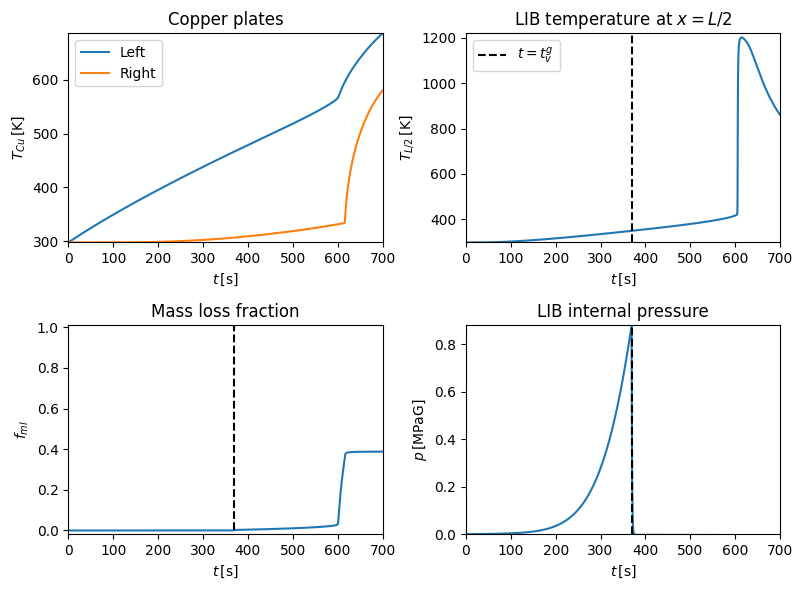

<Figure size 640x480 with 0 Axes>

In [17]:
if make_line_plots:
    
    fig, axs = plt.subplots(2,2)
    fig.set_size_inches(8,6)

    ax = axs[0][0]
    ax.plot(sol.t, sol.T_Cu_L, label="Left")
    ax.plot(sol.t, sol.T_Cu_R, label="Right")
    ax.set_xlabel(r'$t\, \text{[s]}$')
    ax.set_ylabel(r'$T_{Cu} \, \text{[K]}$')
    ax.set_xlim([0.0, t_max])
    ax.set_ylim([np.min([sol.T_Cu_L, sol.T_Cu_R]), np.max([sol.T_Cu_L, sol.T_Cu_R])])
    ax.set_title("Copper plates")
    ax.legend()

    ax = axs[0][1]
    ax.plot(sol.t, sol.T[idx_mid, :])
    ax.set_xlabel(r'$t\, [\text{s}]$')
    ax.set_ylabel(r'$T_{L/2} \, [\text{K}]$')
    ax.set_xlim([0.0, t_max])
    ax.set_ylim(bottom=T0, top=np.max(sol.T))
    ax.plot([lib.t_v_g, lib.t_v_g], [T0, np.max(sol.T)], 'k--', label=r"$t=t_v^g$")
    ax.legend()
    ax.set_title(r"LIB temperature at $x=L/2$")

    ax = axs[1][0]
    ax.plot(sol.t, f_ml)
    ax.set_xlabel(r'$t\, \text{[s]}$')
    ax.set_ylabel(r'$f_{ml}$')
    ax.set_xlim([0.0, t_max])
    ax.set_ylim(top=1.01)
    ax.plot([lib.t_v_g, lib.t_v_g], [0.0, 2.0], 'k--')
    ax.set_title("Mass loss fraction")

    ax = axs[1][1]
    ax.plot(sol.t, sol.p/1.0e6)
    ax.set_xlabel(r'$t\, \text{[s]}$')
    ax.set_ylabel(r'$p\, \text{[MPaG]}$')
    ax.set_xlim([0.0, t_max])
    ax.set_ylim(bottom=-0.001, top=np.max(sol.p/1.0e6))
    ax.plot([lib.t_v_g, lib.t_v_g], [0.0, np.max(sol.p/1.0e6)], 'k--')
    ax.set_title("LIB internal pressure")

    plt.tight_layout()
    plt.show()

    plt.savefig('outputs/result_lines.png', dpi=300)

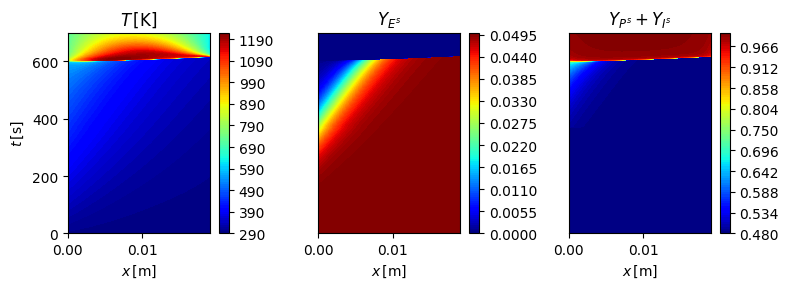

<Figure size 640x480 with 0 Axes>

In [18]:
if make_contour_plots:

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(8,3)

    ax = axs[0]
    contour = ax.contourf(x_grid, sol['t'], sol.T.T, levels=101, cmap='jet')
    ax.set_xlim([0, L])
    ax.set_xlabel(r'$x\, [\text{m}]$')
    ax.set_ylabel(r'$t\, [\text{s}]$')
    cbar = fig.colorbar(contour, ax=ax)
    ax.set_title(r'$T\, [\text{K}]$')

    ax = axs[1]
    contour = ax.contourf(x_grid, sol['t'], sol.rhoY[:,species_idx['E^s'],:].T / np.sum(sol.rhoY, axis=1).T, levels=101, cmap='jet')
    ax.set_xlim([0, L])
    ax.set_xlabel(r'$x\, [\text{m}]$')
    ax.set_yticks([])
    cbar = fig.colorbar(contour, ax=ax)
    ax.set_title(r'$Y_{E^s}$')

    ax = axs[2]
    contour = ax.contourf(x_grid, sol['t'], sol.rhoY[:,species_idx['P^s+I^s'],:].T / np.sum(sol.rhoY, axis=1).T, levels=101, cmap='jet')
    ax.set_xlim([0, L])
    ax.set_xlabel(r'$x\, [\text{m}]$')
    ax.set_yticks([])
    cbar = fig.colorbar(contour, ax=ax)
    ax.set_title(r'$Y_{P^s} + Y_{I^s}$')

    plt.tight_layout()
    plt.show()

    plt.savefig('outputs/result_contours.png', dpi=300)